# Notebook example of genetic algorithms for optimization problems 
In this notebook we are using the deap framework for the usecase of the Schaffer function as a general optimization problem.

In [1]:
# Notebook options
%matplotlib inline
# Main imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from copy import deepcopy

## 1. The Schaffer N. 1 multi-objective function

#### Same as in our simple example
---
The Schaffer N. 1 multi-objective function is a testfunction for optimization problems, which consists of two simple functions. It takes into account only x and as the two functions span a curve, it can be used to create a nice plot for visualization of the optimization steps. The two functions building the Schaffer function are:
- f1(x) = x <sup>2</sup>
- f2(x) = (x - 2) <sup>2</sup>

In [2]:
# Schaffer functions f1, f2
def schaffer_f1(x):
    return x ** 2

def schaffer_f2(x):
    return (x - 2) ** 2

---

#### New

This time we want to modify the Schaffer function in order to make it a more complex problem. Therefor we will introduce a helper function that will generate x values based on another input array. This way we can optimize the Schaffer function by constantly updating the array to try and find our x in [0, 2] and thus minimize both the lower functions as given above.

Now let's define the helper function:

g(a<sup>n</sup>) = a<sub>0</sub> + a<sub>1</sub> * 2<sup>1</sup> * a<sub>2</sub> * 2<sup>2</sup> + ... + a<sub>n</sub> * 2<sup>n</sup>

In [1]:
# Our helper function to create x values from an array
def g(array):
    x = 0
    for exponent, a in enumerate(array):
        x += a * 2 ** exponent
        
    return x

This function should return x values somewhere in the range of [-10<sup>5</sup>, 10<sup>5</sup>]. It can handle our objectives for 
* an array of length 12
* the array values being in range [-4, 4]

In [4]:
# Minimum and maximum of our values -4, +4
A_RANGE = (-4, 4)

# Number of values needed for our function
A_NUMS = 12

It's extremes are 
* -16380 for all values being -4 
* +16380 for all values being +4.

This function has a drawback as for a high number of g calls, all initiated with arrays of uniform distributed values, we receive normal distributed x values. We can assume that this is caused by the multiplication that makes polynomial parts resulting from array values from either side (-4, +4) converge near 0.   

In order to avoid this we use a workaround by shifting the function by a constant and thus receive the following modified helper function:

g_mod(a<sup>n</sup>) = g(a<sup>n</sup>) + C

In [5]:
def g_mod(array, const):
    # Notice: We assume the function to be used with an input array of max size 12 for testing purposes.
    # Notice: With uniform distributed random values as input array, this function still doesn't generate 
    # uniform distributed x values. This is due to the fact that each part of the polynom is multiplied 
    # with the corresponding number of the array and both sides either from -4 or +4 approaching 0 results 
    # in less impact and thus in a value closer to 0! For this case we will shift the function by a number 
    # that moves the functions modal away from 0.
    # x += 10000
    x = g(array) + const
    
    return x

 
With our above defined and expected array size (12) and our limits (-4, 4), we add a constant C=10000. The shift can be seen in the below plotted comparison between both functions.

In [6]:
G_MOD_CONST = 10000

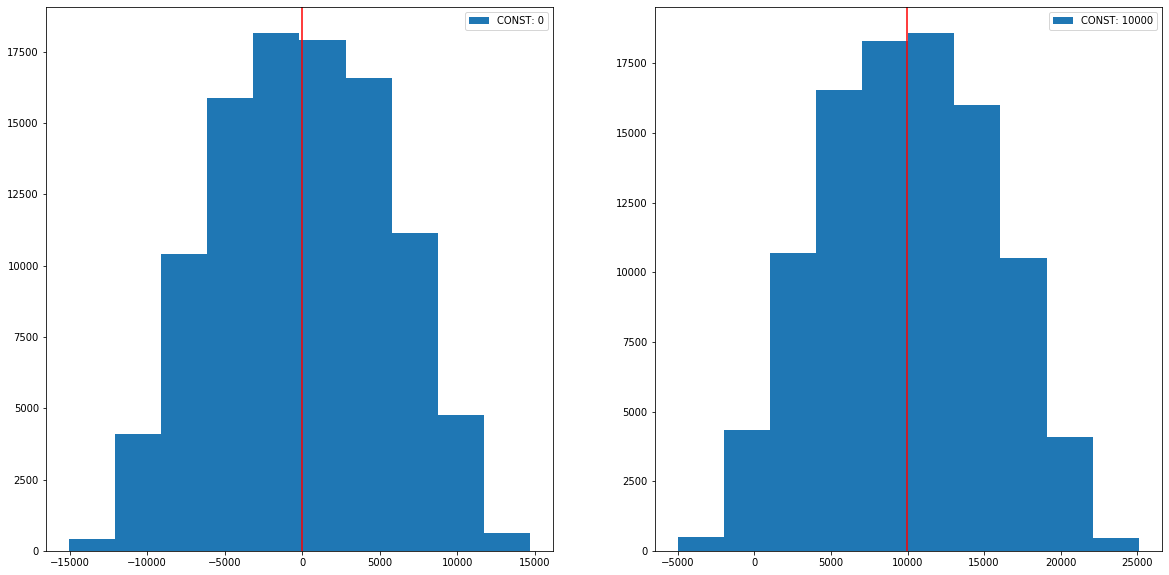

In [7]:
# Function for creating a random individual
def gen_fun():
    rand_nums = list(np.random.random(12) * np.abs(np.diff((-4, 4))) + np.min((-4, 4)))
    
    return rand_nums

# Number of individuals
NUM_IND = 100000

# Initializing plot
f = plt.figure(figsize=(20, 10))

# Add three subplots for the different states
ax1 = f.add_subplot(1, 2, 1)
ax2 = f.add_subplot(1, 2, 2)

for ax, const in zip([ax1, ax2], [0, G_MOD_CONST]):
    rand_pop = [g_mod(gen_fun(), const) for ind in range(NUM_IND)]
    ax.hist(rand_pop, label="CONST: {}".format(const))
    ax.legend()
    ax.axvline(x=np.array(rand_pop).mean(), ymin=0, ymax=1000000, color="red")
    
    # stats.mode(np.round(rand_pop))[0]
plt.show()

## 2. Creating additional functions for Schaffer and individuals

Here we will write our functions to evaluate the Schaffer function as well as create individuals for our population. Here our make_individual will also take a second argument that defines the number of properties of an individual as given by A_NUMS in this case. A_NUMS has been defined above as 12.

In [8]:
# Range of values used for x1, x2; use for standard plot of functions
X_RANGE = (-100000, 100000)

x_vals = np.arange(X_RANGE[0], X_RANGE[1] + 1, 0.1)

# Schaffer evaluation function
def schaffer_eval(individual):
    # First get our x by calling the g function with unpacked individual
    x = g_mod(individual, G_MOD_CONST)
    
    # Now return both function values
    return schaffer_f1(x), schaffer_f2(x)

# Function for creation of individual
# One random value [0, 1] is taken and projected on the range of limits as given in the parameter x_range
def make_individual(a_range, a_nums):
    return list(np.random.random(a_nums) * np.abs(np.diff(a_range)) + np.min(a_range))

# Vectorize Schaffer functions for plotting purpose
schaffer_f1_vec = np.vectorize(schaffer_f1)
schaffer_f2_vec = np.vectorize(schaffer_f2)

## 3. Creating the deap toolbox

We will again create our toolbox with deap, this time only with different individuals. 

The deap library <sup>[Github](https://github.com/DEAP/deap) [Docs](https://deap.readthedocs.io/en/master/)</sup> is a framework that offers everything one needs to simply setup a genetic algorithm concept. Therefor it provides the user with a set of initilization-, crossover-, mutation- as well as selection-functions that include proven methods. The way deap works makes it very easy to setup a run-ready system.


The following code initiates a deap framework with the following objectives:
- having a multi-objective optimization looking for minimization 
    * weights is a tuple with two values (weights = (-1, -1))
    * negative for minimization!
- creating a population of individuals which all have a random integers in a given range which stands for a reasonible limit for the function where function values behind those limits do not change relevant anymore
- giving an evaluation function which shall be optimized by the genetic algorithm (here: defined schaffer_eval)
    * the function is rewritten as ackley_eval where the only argument is the individual
    * inside there's one call of the ackley function with the above defined a, b, c parameters and the individual which is used for the given dimensions
- giving the function for mating which is chosen to be simulated binary bounded
    * this simulates a binary mating
    * in binary mating binary-coded values are used instead of real-coded ones
    * simulated binary crossover intends to replace this function by using distribution functions on which the real-coded values are crossed 
- giving the function for mutation which is chosen to be polynomial bounded
    * polynomial bounded mutation intends to create a mutation based on a polynomial probability function
    * values are limited by their bounds
- giving the function for selection which is here chosen as selNSGA2
    * selNSGA2 does a selection based on multiobjective optimization

It follows the article of [Deb, 2002](https://pdfs.semanticscholar.org/dc4e/c99d4201affa93f404c6b4e4f8538d07aeb5.pdf), who have developed the NSGA-2 algorithm and also have shown some composition of optimization solving by combining simulated binary bound crossover and polynomial bound mutation.
    
The mutation parameters given are:
- ETA
    * set to be 20
    * a parameter that defines how similiar children should be to their parents (could be called crowding distance)
    * Deb chose this value size without further explanation and it's still unclear what value exactely to choose
- LOW
    * set to be -1000
    * lower bound of our value
    * through mating and mutation values can't go lower then this value!
- UP
    * set to be 1000
    * upper bound of our value
    * through mating and mutation values can't go higher then this value!
- INDPB
    * set to be 0.05
    * independent probability value which is taken as gate to choose if mutation will happen or not
    * another check after MUTPB
- CXPB
    * set to be 0.5
    * crossing probability for which a random value has to be lower to make crossing happen
- MUTPB
    * set to be 0.2
    * mutation probability for which a random value has to be lower to make mutation happen

In [9]:
ETA = 20
LOW = A_RANGE[0]
UP = A_RANGE[1]
INDPB = 0.05
CXPB = 0.5 
MUTPB = 0.2

# Import of deap modules
from deap import base, creator, tools, algorithms

# Module base is used to create a container for the individuals that holds the fitness function as well as later added parameters (here: pair of x1, x2)
# First FitnessMin class is registered with weights according to optimization objective
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# Second the Individual class having a list container with parameters and a fitness value is created
creator.create("Individual", list, fitness=creator.FitnessMin)

# Now toolbox with genetic algorithm functions is created
toolbox = base.Toolbox()
# Candidate (container for individual) is added with function make_individual that creates a pair of x1, x2 values; function is called with limits of x1, x2 respectively
toolbox.register("candidate", make_individual, A_RANGE, A_NUMS)
# Individuals are created by calling the candidate function which again calls the make_individual function
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.candidate)
# Population is created putting a number of individuals in a list
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Evaulate function is set as ackley_eval as defined before
toolbox.register("evaluate", schaffer_eval)

# Function for mating is set to be simulated binary bounded (means parameters can't leave the given range of bounds)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=ETA, low=LOW, up=UP)
# Function for mutatiion is set to be polynomial bounded and again parameters can#t leave their bounds
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, low=LOW, up=UP, indpb=INDPB)
# toolbox.register("select", tools.selNSGA2)
# Selection is set to be selBest which simply picks k best individuals of population to be the new generation population start
toolbox.register("select", tools.selNSGA2)

C:\Users\benjamin\Anaconda3\envs\inowas\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


## 4. Running the genetic algorithm on a population of modified individuals
We have set up our toolbox and now want to see what the algorithm is capable of. Again we will use easimple as guidance. This means mating and mutation is independent of each other and can happen at the same time/generation.

In [10]:
# Population size
POP_SIZE = 80
# Generations per step
GEN_PER_STEP = 1
# Number of steps
GEN_STEPS = 500
# Popultion is build with size
pop = toolbox.population(n=POP_SIZE)
# Hall of fame is build as a pareto front (because of multi-objective optimization!)
hall_of_fame = tools.ParetoFront()

# Empty array for best individuals of every step is created
best_of_step = []

# For loop through steps
for step in range(GEN_STEPS):
    # Simple evolution applied; feedback returned to hall of fame; population is returned to overwrite success
    pop, _ = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, GEN_PER_STEP, halloffame=hall_of_fame, verbose=False)
    # Current hall of fame is copied and appended to best of
    best_of_step.append(list(deepcopy(hall_of_fame)))

C:\Users\benjamin\Anaconda3\envs\inowas\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\benjamin\Anaconda3\envs\inowas\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


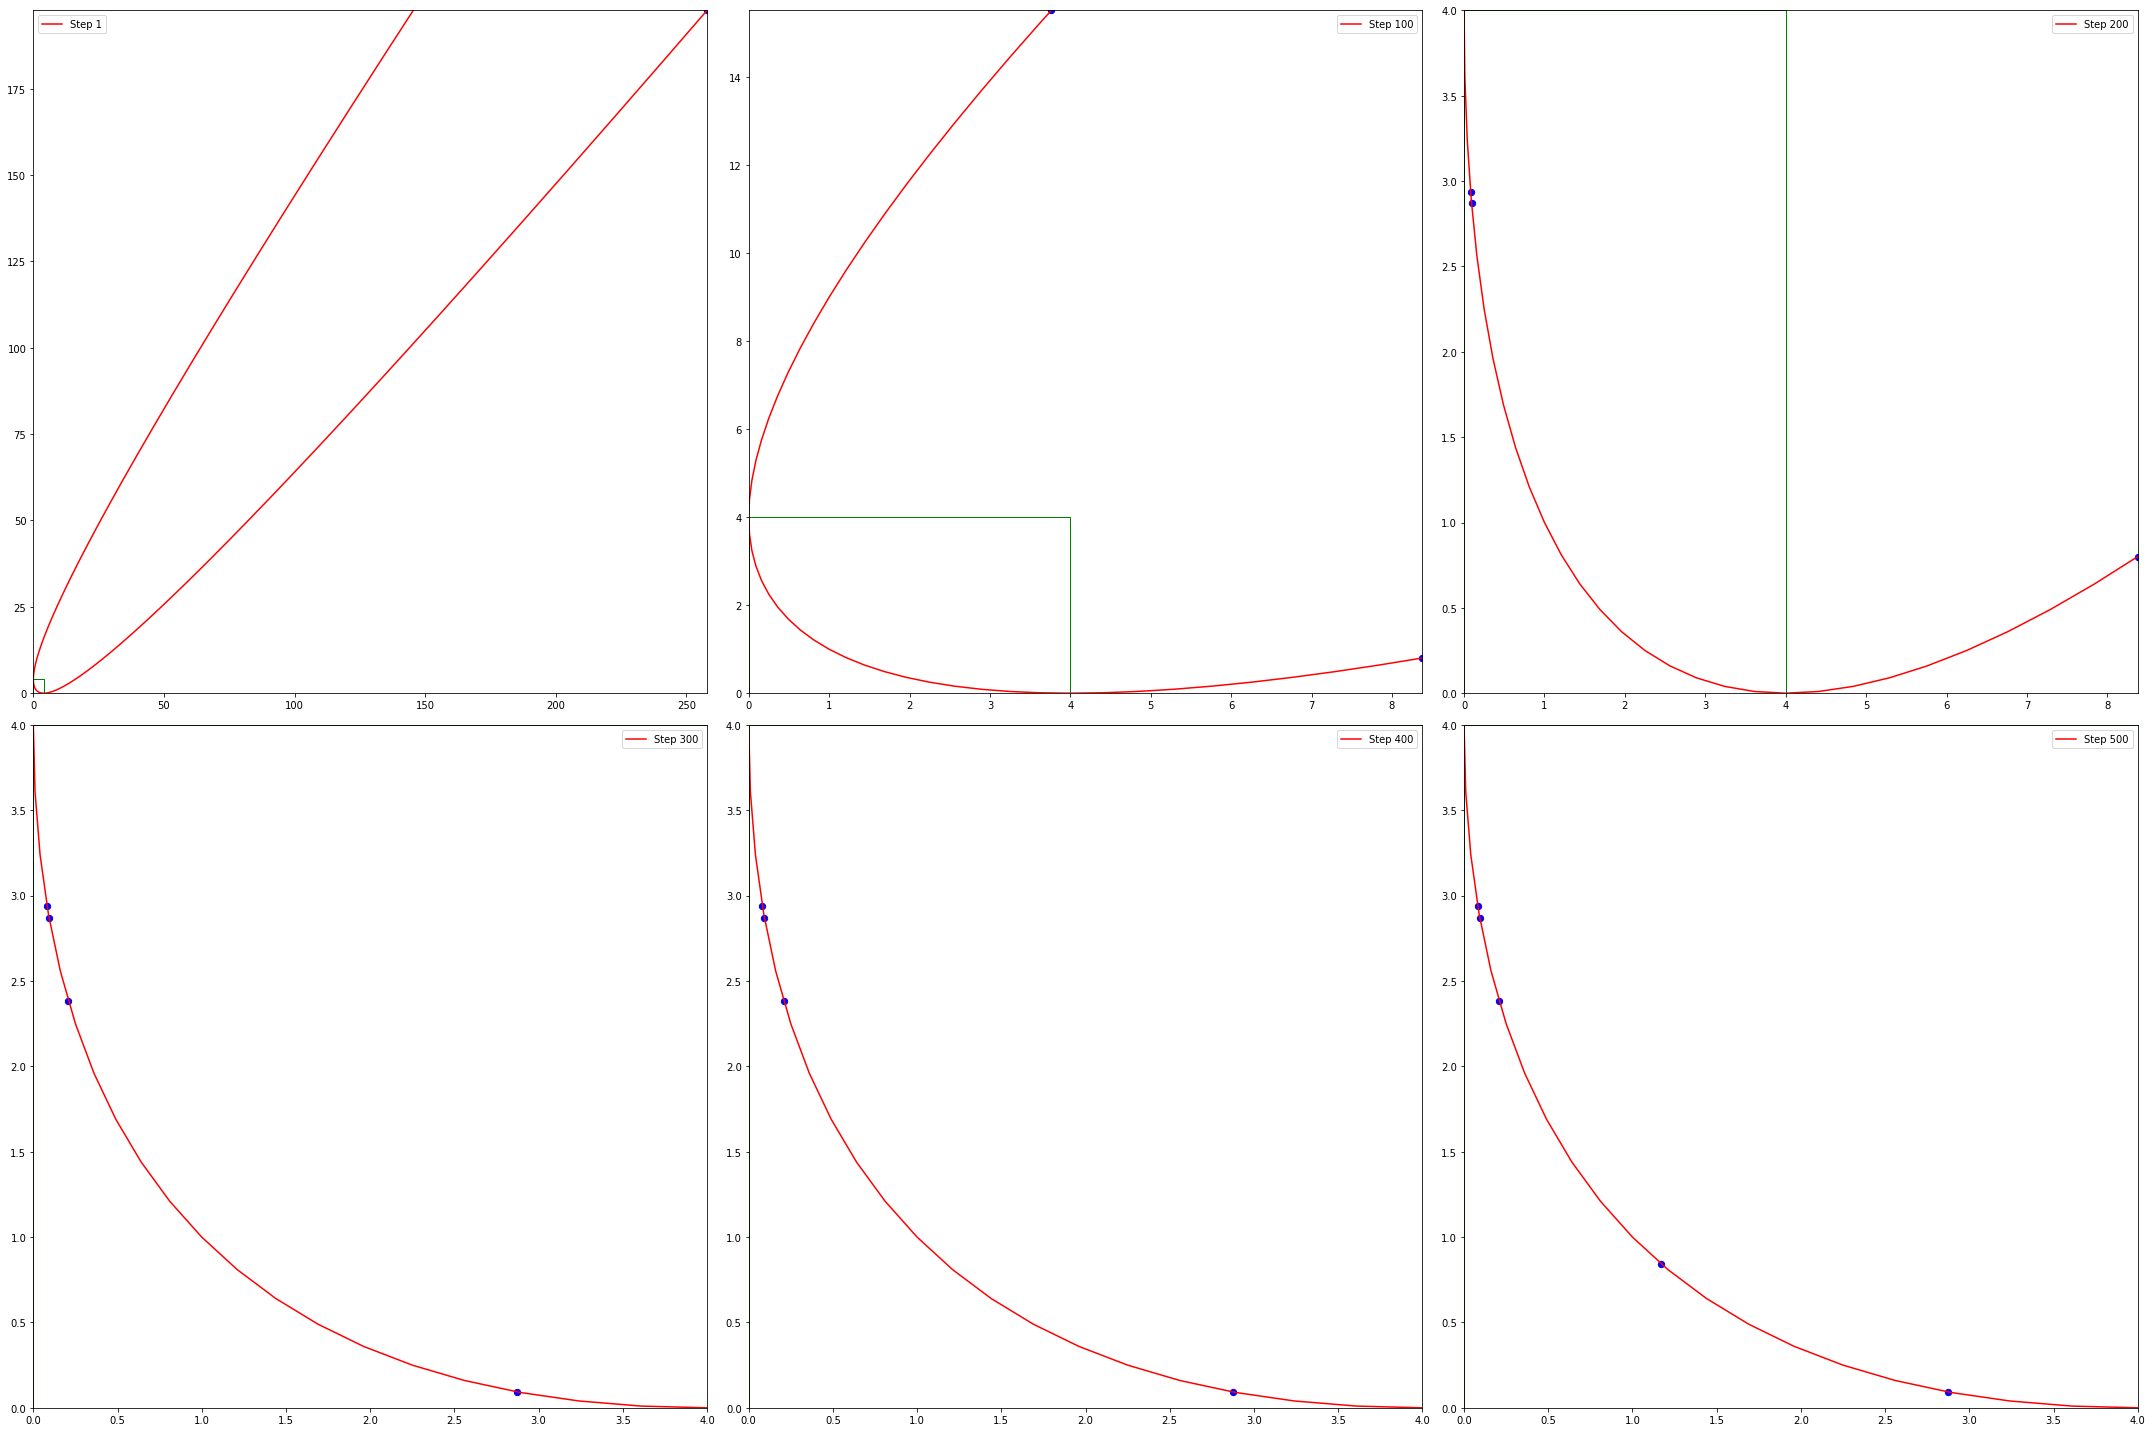

In [11]:
SCHAFFER_OPT = [0, 2]

# Create an empty figure, this time broader for space of three plots!
f = plt.figure(figsize=(30, 20))

# Add three subplots for the different states
ax1 = f.add_subplot(2, 3, 1)
ax2 = f.add_subplot(2, 3, 2)
ax3 = f.add_subplot(2, 3, 3)
ax4 = f.add_subplot(2, 3, 4)
ax5 = f.add_subplot(2, 3, 5)
ax6 = f.add_subplot(2, 3, 6)

# Give indizes of which solutions are picked
# np.linspace to get evenly distributed numbers; astype for integers, which are needed for array subset 
INDIZES = np.floor(np.linspace(0, len(best_of_step) - 1, 6)).astype(int)

# Loop through indizes combined with axes of subplots to create the graphs
for ax, ind in zip([ax1, ax2, ax3, ax4, ax5, ax6], INDIZES):
    # Calculating function values
    f1_values = schaffer_f1_vec([g_mod(a_vec, G_MOD_CONST) for a_vec in best_of_step[ind]])
    f2_values = schaffer_f2_vec([g_mod(a_vec, G_MOD_CONST) for a_vec in best_of_step[ind]])
    
    # Create a general plot of the function
    ax.plot(schaffer_f1_vec(x_vals), schaffer_f2_vec(x_vals), c="red", label="Step {}".format(str(ind + 1)))
    
    # Create scatters of the hall of fame solutions
    ax.scatter(f1_values, f2_values, c="blue", s=40)
    
    # Set plot limits
    ax.set_xlim((0, max(max(schaffer_f1_vec(SCHAFFER_OPT)), np.max(f1_values))))
    ax.set_ylim((0, max(max(schaffer_f2_vec(SCHAFFER_OPT)), np.max(f2_values))))
    
    # Create rectangle
    rect = Rectangle((0, 0), max(schaffer_f1_vec(SCHAFFER_OPT)), max(schaffer_f2_vec(SCHAFFER_OPT)), edgecolor="g", facecolor="none")
    # Adding to plot
    ax.add_patch(rect)
            
    ax.legend()
    
plt.tight_layout()
plt.show()

## 5. Running linear optimization on the output of the genetic algorithm
After having run the genetic algorithm, the generated solutions are limited to the crossover and mutation functions as a method of improvement. However, there's another chance of improving the solution by taking a look at it with linear optimization. Here we will use the Nelder-Mead algorithm from [Nelder and Mead (1965)](https://watermark.silverchair.com/7-4-308.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAk4wggJKBgkqhkiG9w0BBwagggI7MIICNwIBADCCAjAGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMNsrVIyISYuR0c5VtAgEQgIICAWtLM8qDcle82Fz_9rcketNPqLK-JlFEVtohuFNQqVRYsmPZUjjUE4_OqxZ3XK0LH4fOtOx6EnSdEf1OgMrGB29OTY6nndJGaV2AXXO9_2EAtPxgCQJvf8EiVZfmUts_ZNy6FB3BlUQPlGE8tgS_ph1fintBjBFv0HKV1DQ7Cpr9Sxm60fPrUaExCbYZ0m1-_RIHIfkCScmo8YrJ8x1EaM6J4Sf8ph-v66zM8IpXNSorPPWuuFHS16HM1333rl7l8bWv1qGdqNdTRM4PPEGNgJwdepdODj18_1XIsodYi9k1JkR6vnFofWzJGrTyiXGPe5Q_IhH3inkp5UXCHEq3TKfIAAp1Ot3BVFlaQ6QgcFx0BQoEkR-ClkjG97bj9DsvjO6g0NHNwFAokjhx3hY7kh7xDR3GaRYQWqFvuOMSjTVThefqBQiyU_W-Z0pPYidbTXtq5RuQGEFSLWw88hgIZSuUbae5bW0G-KQviAbeXwppbROFDbjDDa1DsAN-3aZlJOllVLhCBD99cSnLPHsj-YPjiLi3wfgQ35t9QSzLZmzadkSzW4fnX3ZXLAbFYAvNjpyOHiBGpzamcY8jv_V3BLA7ABwb0jkrdB5kV1X6Qvf959k8O7c7SoT48woftg-mStnC3nQ_gobo57ZMhQDf54uAnr7TfZXuwG5hqs1ODztTzw).

The Nelder-Mead algorithm is used for non-linear optimization so that the locally found solution can be set to the local optimum. This is done by spanning a simplex (convex hull), which then can be modified by either mirroring, expanding, contracting or compressing in order to reach the local optimum point.

In order to run the linear optimization first we have to simplify our evaluation function to a scalar, which means it should only return one single objective value. Therefor in this example we choose the sum of the two function returns.

In [12]:
# Imports
# Import of solvers NelderMeadSimplex
from mystic.solvers import NelderMeadSimplexSolver
# Import of the termination criteria which here is CRT, that is based on relative difference between candidates for termination
from mystic.termination import CandidateRelativeTolerance as CRT

# Schaffer evaluation function is again simplified by reducing the solution to a scalar of a sum of both function returns
def schaffer_scalar(individual):
    return sum(schaffer_eval(individual))

# Give dimension size for solver (this spans the simplex)
DIM_SIZE = A_NUMS

# Set initial point to be the best solution of the previously generated solutions by the genetic algorithm
best_gen = hall_of_fame[0]

# Initiate solver with class NelderMeadSimplexSolver and dimension size as argument
solver = NelderMeadSimplexSolver(DIM_SIZE)

# # Initial point is best solution
solver.SetInitialPoints(best_gen)
# # Termination criteria is set to be CRT
solver.SetTermination(CRT())

# # Function to solve is schaffer_eval
solver.Solve(schaffer_scalar)

# obtain the solution
best_gen_opt = solver.Solution()

## 6. Creating a comparison graph for the best generated solution and the linear optimized solution

Now that the best solution as given by the genetic algorithm has been linear optimized we want to conclude with a comparison of both values and see what has changed through this last step. To do so we'll create a graph with both points in it.

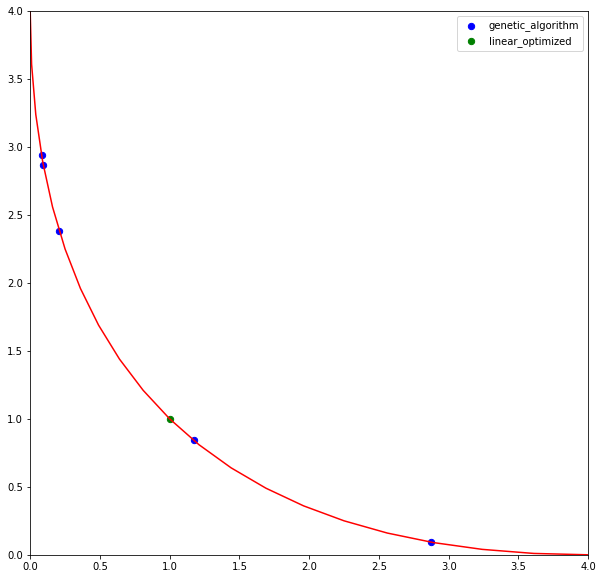

In [13]:
# Create an empty figure, this time broader for space of three plots!
f = plt.figure(figsize=(10, 10))

# Create a general plot of the function
plt.plot(schaffer_f1_vec(x_vals), schaffer_f2_vec(x_vals), c="red")

# Create scatters of the hall of fame solutions
plt.scatter(schaffer_f1_vec([g_mod(best_ind, G_MOD_CONST) for best_ind in hall_of_fame]), schaffer_f2_vec([g_mod(best_ind, G_MOD_CONST) for best_ind in hall_of_fame]), c="blue", label="genetic_algorithm", s=40)
plt.scatter(schaffer_f1_vec([g_mod(best_gen_opt, G_MOD_CONST)]), schaffer_f2_vec([g_mod(best_gen_opt, G_MOD_CONST)]), c="green", label="linear_optimized", s=40)

# Add legend
plt.legend()

# Limit the plot to box
plt.xlim((0, max(schaffer_f1_vec(SCHAFFER_OPT))))
plt.ylim((0, max(schaffer_f2_vec(SCHAFFER_OPT))))

plt.show()

As can be seen in the plot the algorithm has moved the solution towards the point in (1, 1), which in this case is the best solution we can get. This way the linear optimization was successfull.